## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### 1. Compute the camera calibration parameters using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
successes = 0
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # cv2.findChessboardCorners() needs 8-bit image format
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        successes += 1
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print("Unable to find chessboard corners for", fname)

print("Camera calibration points computed from {} images.".format(successes))

Unable to find chessboard corners for camera_cal\calibration1.jpg
Unable to find chessboard corners for camera_cal\calibration4.jpg
Unable to find chessboard corners for camera_cal\calibration5.jpg
Camera calibration points computed from 17 images.


Output indicates chessboard corners are not found for calibration images 1, 4, and 5. 
The OpenCV documentation for ```findChessboardCorners``` notes:
    
>The function requires white space (like a square-thick border, the wider the better) around the board 
>to make the detection more robust in various environments. Otherwise, if there is no border and the background is dark, the outer black squares cannot be segmented properly 
>and so the square grouping and ordering algorithm fails.

These failing images lack the required border:
<img src="./camera_cal/calibration1.jpg" width="250" /> 
<img src="./camera_cal/calibration4.jpg" width="250" /> 
<img src="./camera_cal/calibration5.jpg" width="250" />

---
### 2. Compute distortion coefficients and apply correction to test image
Using objpoints and imgpoints from previous cell, compute distortion coefficients to calibrate camera and output undistorted test image.

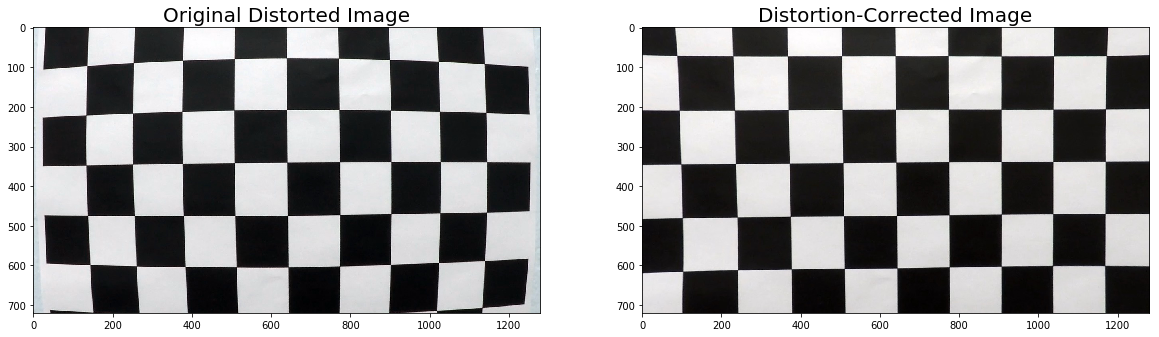

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Distorted Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Distortion-Corrected Image', fontsize=20)

Apply correction to all images in test_images directory. Save corrected images in output_images directory. 
Compare example image with distortion correction applied.

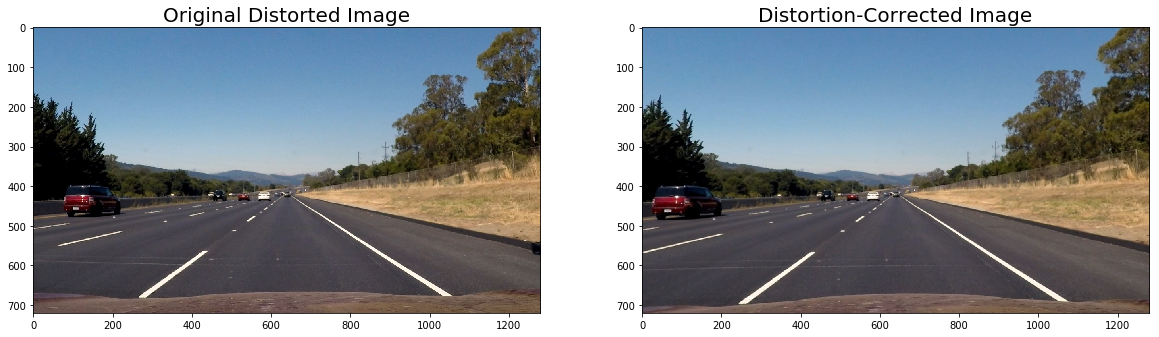

In [3]:
# Make a list of test images
images = glob.glob('test_images/*.jpg')

# Step through the list and search for chessboard corners
for idx, fpath in enumerate(images):
    img = cv2.imread(fpath)   
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    output_path = 'output_images/ud-' + fpath[12:]
    #print(output_path)
    cv2.imwrite(output_path, dst)
    
# compare original and distortion-corrected image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.imread('output_images/ud-straight_lines2.jpg')
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Distorted Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Distortion-Corrected Image', fontsize=20)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

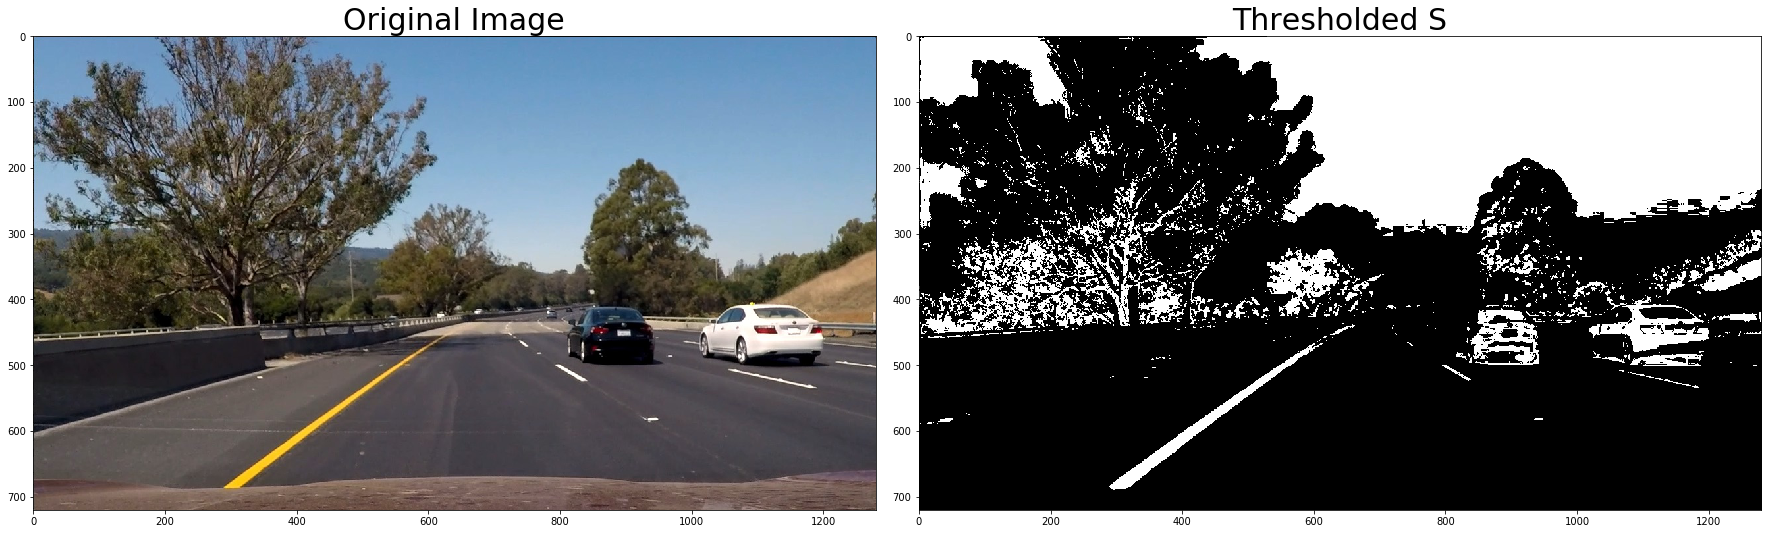

In [4]:
import matplotlib.image as mpimg

def hls_select(img, thresh=(0, 255)):
    """
    Convert to HLS color space
    Apply a threshold to the S channel
    Return a binary image of threshold result
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

image = mpimg.imread('test_images/test6.jpg')
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

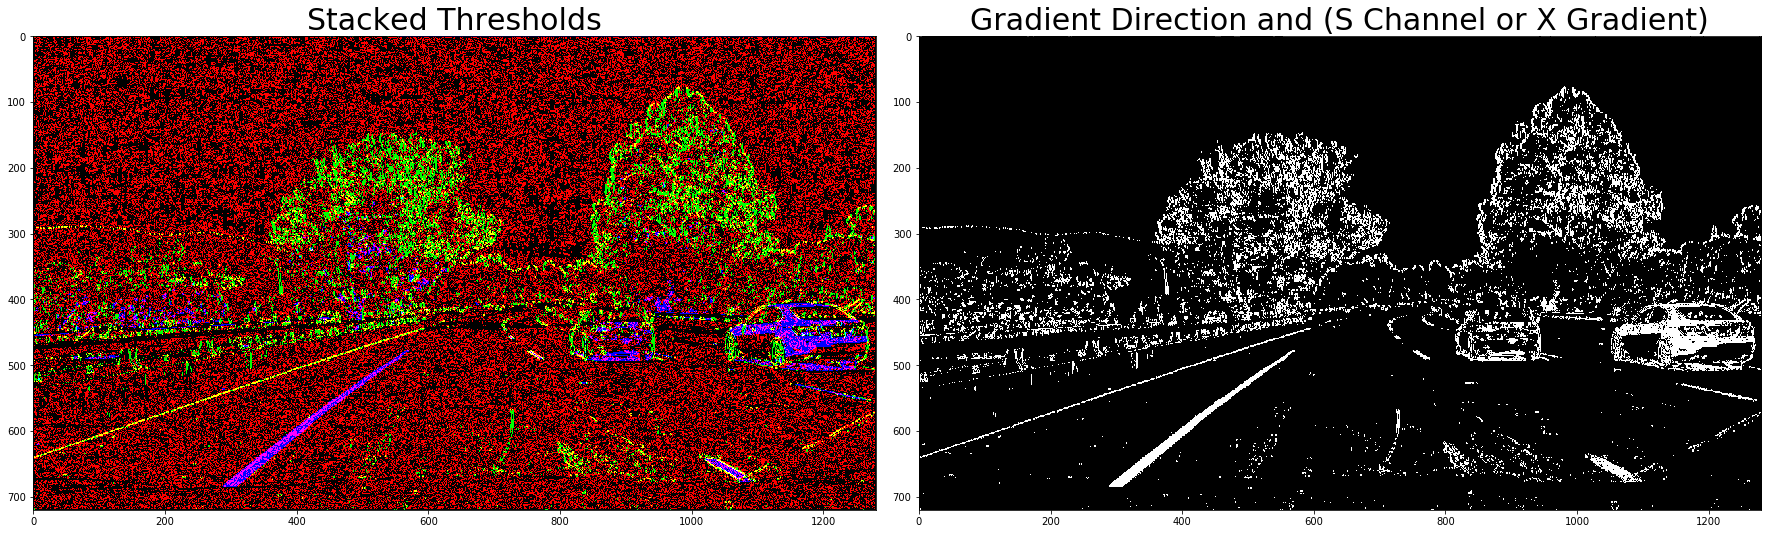

In [19]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), dir_thresh=(0.7, 1.3)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in x
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    gradbinary = np.zeros_like(absgraddir)
    gradbinary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    stacked_binary = np.dstack(( gradbinary, sxbinary, s_binary)) * 255
    stacked_binary = stacked_binary.astype(np.uint8) # was float64
    combined_binary = np.zeros_like(sxbinary)
    #combined_binary[(gradbinary == 1) & ((s_binary == 1) | (sxbinary == 1))] = 1
    #combined_binary[(gradbinary == 1)] = 1
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return stacked_binary, combined_binary
    
#image = mpimg.imread('test_images/test6.jpg')
image = mpimg.imread('test_images/test1.jpg')
stacked_binary, combined_binary = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(stacked_binary)
ax1.set_title('Stacked Thresholds', fontsize=30)

ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Gradient Direction and (S Channel or X Gradient)', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

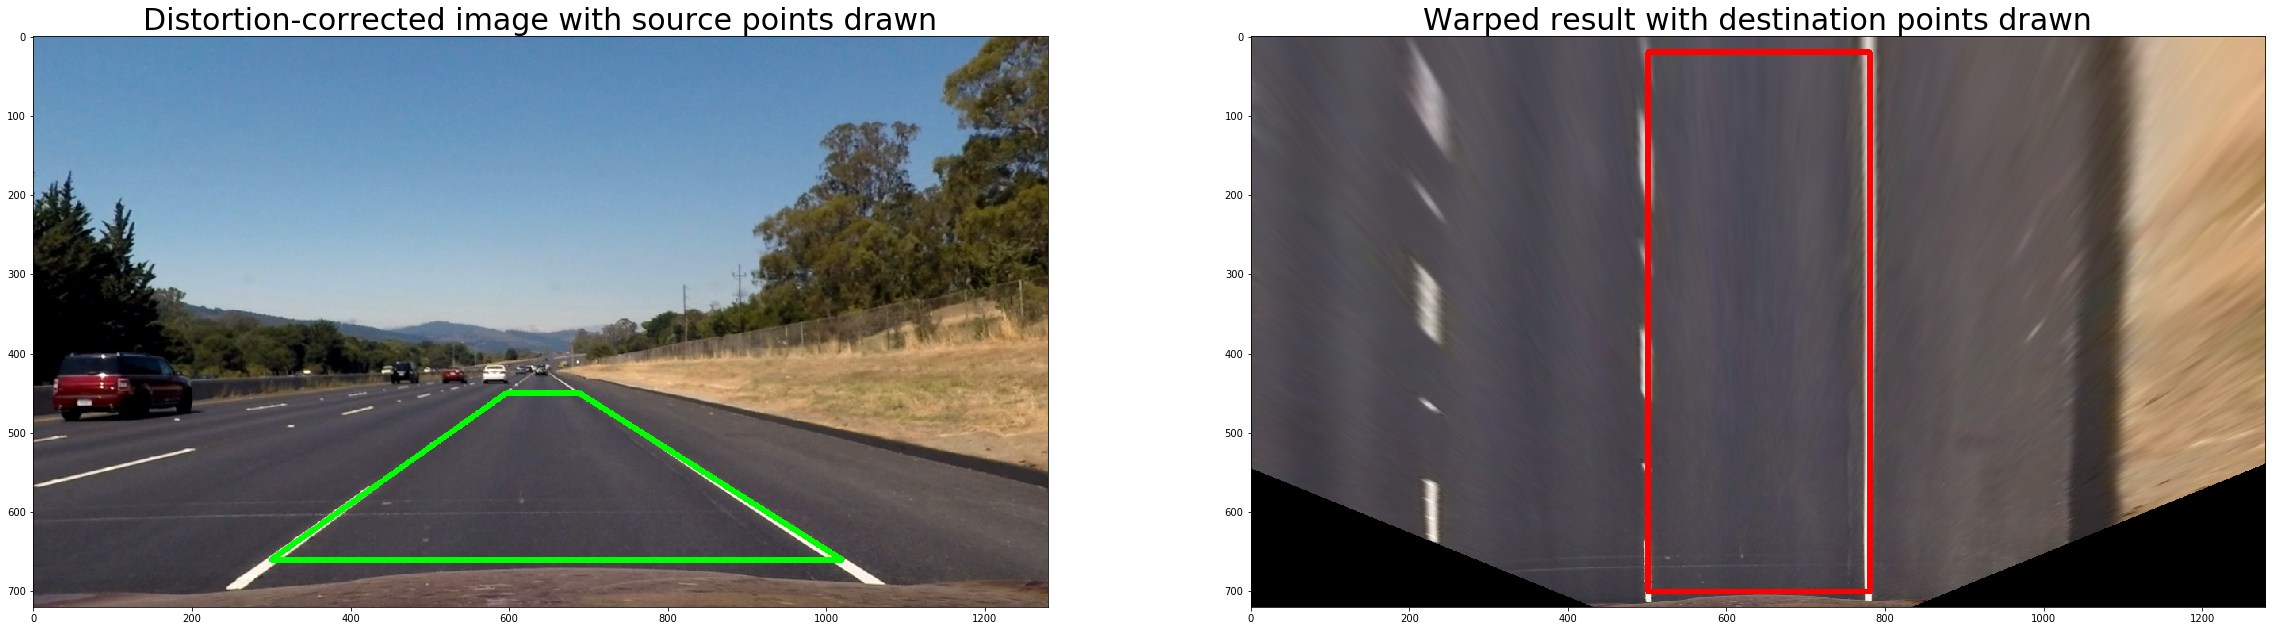

In [6]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = cv2.imread('test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# lane line center points from source image
left_top = [596, 450]
right_top = [689, 450]
left_bottom = [300, 660]
right_bottom = [1020, 660]
src_pts = [left_bottom, left_top, right_top, right_bottom]
src = np.float32(src_pts)

# axis-oriented rectangle for target image to produce "bird's eye view"
left = 500 
right = 780 
top = 20 
bottom = 700
tgt_pts = [[left, bottom], [left, top], [right, top], [right, bottom]]
tgt = np.float32(tgt_pts)

# undistort using mtx and dist
dst = cv2.undistort(img, mtx, dist, None, mtx)

# compute transform for warp (and back)
M = cv2.getPerspectiveTransform(src, tgt)
Minv = cv2.getPerspectiveTransform(tgt, src)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)

# save warped image to measure x y scale
cv2.imwrite('output_images/warped.png', warped)

# draw green src points on undistorted, but unwarped image
pts = np.array(src_pts)
dst_with_lines = dst
cv2.polylines(dst_with_lines, [pts], True, (0,255,0), 5)

# draw red tgt points on warped image
pts = np.array(tgt_pts)
warped_with_lines = warped
cv2.polylines(warped_with_lines, [pts], True, (255,0,0), 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 15)) 
ax1.imshow(dst_with_lines) 
ax1.set_title('Distortion-corrected image with source points drawn', fontsize=30)
ax2.imshow(warped_with_lines)
ax2.set_title('Warped result with destination points drawn', fontsize=30)


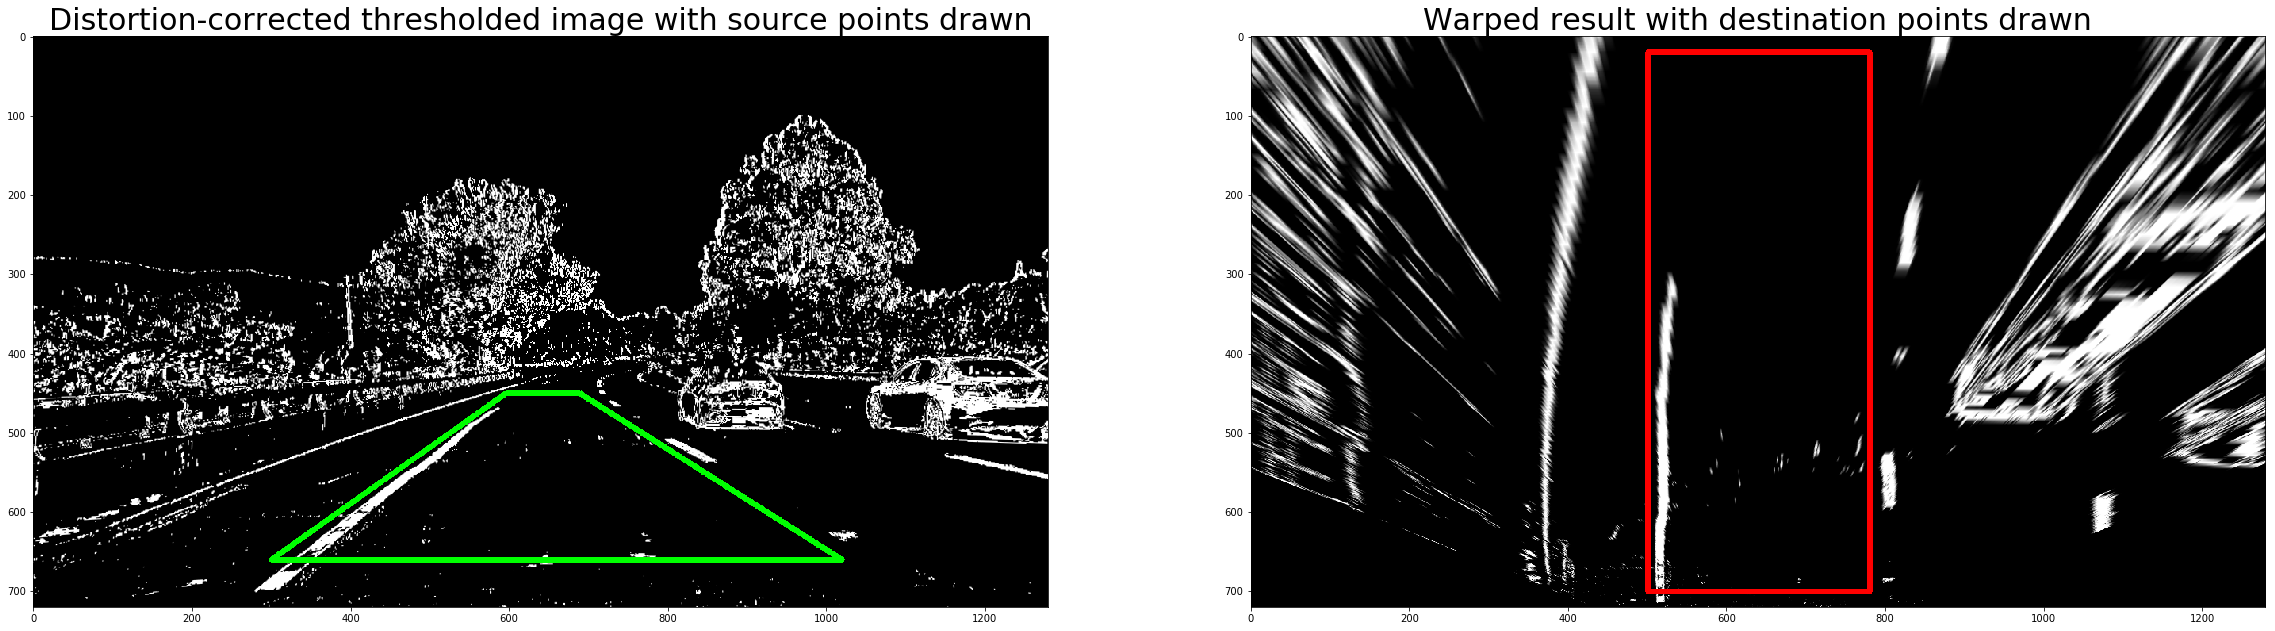

In [20]:
# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load( open( "camera_cal_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

#image = mpimg.imread('test_images/test3.jpg')
image = mpimg.imread('test_images/test4.jpg')
stacked_binary, combined_binary = pipeline(image)

# convert combined_binary to rgb equivalent
combined_rgb = np.dstack((combined_binary, combined_binary, combined_binary))*255

# lane line center points from previous source image
left_top = [596, 450]
right_top = [689, 450]
left_bottom = [300, 660]
right_bottom = [1020, 660]
src_pts = [left_bottom, left_top, right_top, right_bottom]
src = np.float32(src_pts)

# axis-oriented rectangle for target image to produce "bird's eye view"
left = 500 
right = 780 
top = 20 
bottom = 700
tgt_pts = [[left, bottom], [left, top], [right, top], [right, bottom]]
tgt = np.float32(tgt_pts)

# undistort using mtx and dist
dst = cv2.undistort(combined_rgb, mtx, dist, None, mtx)

# compute transform for warp
M = cv2.getPerspectiveTransform(src, tgt)
img_size = (img.shape[1], img.shape[0])
warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)

# make a binary copy of warped
binary_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

# draw green src points on undistorted, but unwarped image
pts = np.array(src_pts)
dst_with_lines = dst
cv2.polylines(dst_with_lines, [pts], True, (0,255,0), 5)

# draw red tgt points on warped image
pts = np.array(tgt_pts)
warped_with_lines = warped
cv2.polylines(warped_with_lines, [pts], True, (255,0,0), 5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 15)) 
ax1.imshow(dst_with_lines) 
ax1.set_title('Distortion-corrected thresholded image with source points drawn', fontsize=30)
ax2.imshow(warped_with_lines)
ax2.set_title('Warped result with destination points drawn', fontsize=30)


### 5. Detect lane pixels and fit to find the lane boundary.

(720, 0)

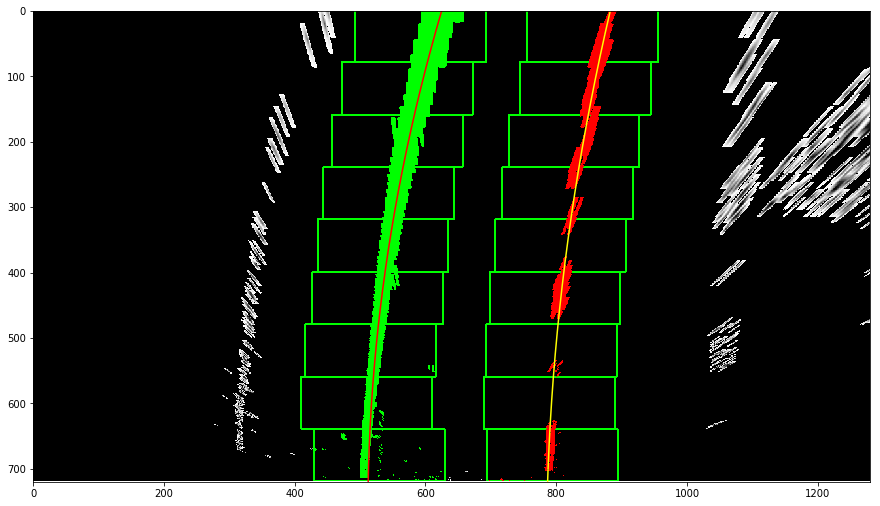

In [8]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#plt.plot(histogram)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0,0]

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(out_img)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

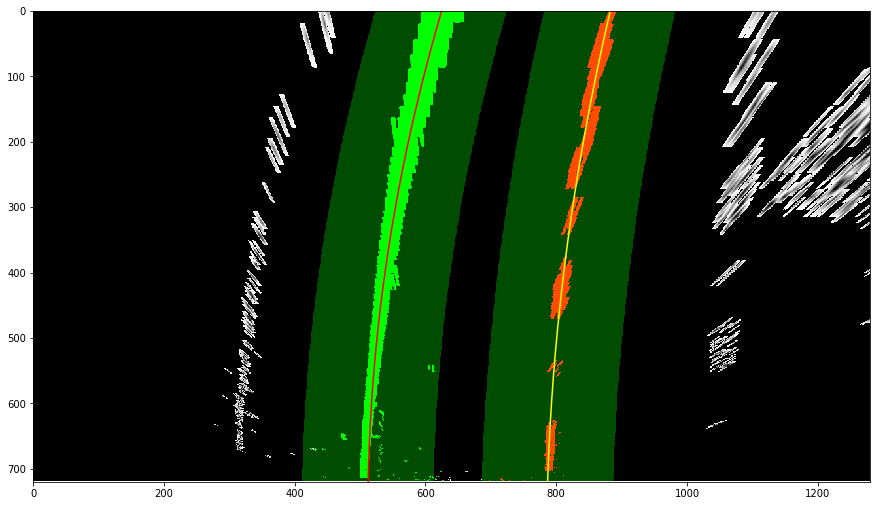

In [9]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(result)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
#left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

# Define conversions in x and y from pixels space to meters
ym_per_pix = 3.0/85 # meters per pixel in y dimension
xm_per_pix = 3.7/275 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print("Radius of curvature in meters: {} (L), {} (R)".format(int(left_curverad), int(right_curverad)))
avg_curvature = int(0.5*(left_curverad + right_curverad))

# compute middle of lane in x pixel coordinates at bottom of image
y = y_eval*ym_per_pix
rightx = right_fit_cr[0]*y**2 + right_fit_cr[1]*y + right_fit_cr[2]
leftx = left_fit_cr[0]*y**2 + left_fit_cr[1]*y + left_fit_cr[2]
ctr = 0.5*(rightx + leftx)
offset = ctr - 640*xm_per_pix
print("Offset = {:.2f} m".format(offset))


Radius of curvature in meters: 244 (L), 331 (R)
Offset = 0.13 m


### 7. Warp the detected lane boundaries back onto the original image.

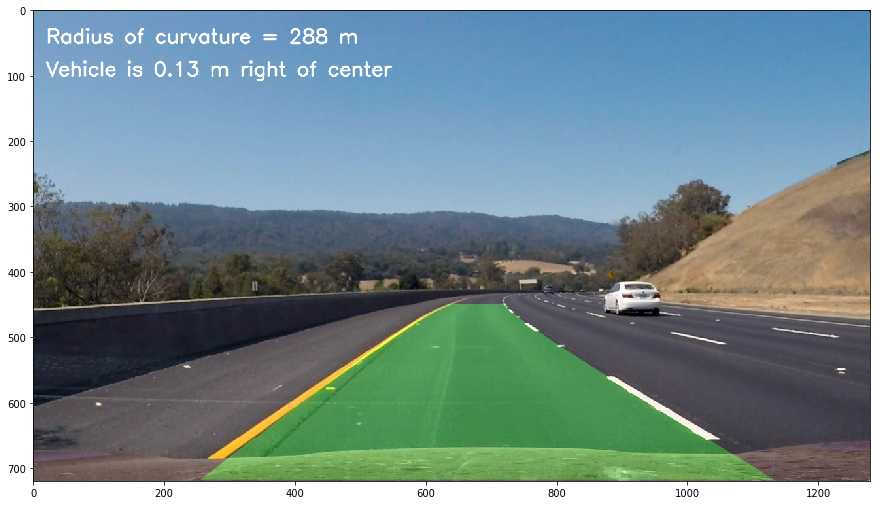

In [13]:
# Create an image to draw the lines on
color_warp = np.zeros_like(warped).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

# Add curvature and offset annotations
curvature_string = 'Radius of curvature = {} m'.format(avg_curvature)
offset_string = 'Vehicle is {:.2f} m '.format(offset)

if (offset > 0):
    offset_string += 'right of center'
else:
    offset_string += 'left of center'
    
font = cv2.FONT_HERSHEY_SIMPLEX

cv2.putText(result, curvature_string, (20,50), font, 1, (255,255,255), 2, cv2.LINE_AA)
cv2.putText(result, offset_string, (20,100), font, 1, (255,255,255), 2, cv2.LINE_AA)

fig = plt.figure(figsize = (15,15)) 
ax = fig.add_subplot(111)
ax.imshow(result)

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

See previous cell output.